# Confidence-Aware RAG with Qubrid using LangGraph

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QubridAI-Inc/qubrid-cookbook/blob/main/Notebooks/Confidence_Aware_RAG.ipynb)

![Qubrid x Langgraph](../../qubrid-cookbook/Assets/Images/Langgraph_x_Qubrid.png)

This notebook demonstrates a confidence-aware RAG agent that transparently shows its confidence in retrieved documents and adapts strategy accordingly. We use a SaaS company's internal knowledge base to show how AI can help teams find policies, procedures, and technical documentation.

The workflow evaluates each document's relevance, displays confidence levels (high/moderate/low), and automatically switches to web search when internal documentation is insufficient.



## System Architecture

![Workflow Diagram](../../qubrid-cookbook/Assets/Images/confidence_aware_rag_workflow.png)

The system uses BAAI embeddings (1024d) for retrieval, GPT OSS 120B for grading and generation, and Tavily API for web search fallback when document confidence is low.

## Setup

We'll use LangGraph for workflow orchestration, FAISS for document retrieval, and Qubrid's GPT OSS 20B for grading and generation.

In [1]:
%%capture
!uv pip install langgraph langchain-core langchain-community faiss-cpu sentence-transformers requests tavily-python

In [2]:
import requests
import json
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from google.colab import userdata
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Qubrid API Configuration
QUBRID_API_KEY = userdata.get('QUBRID_API_KEY')
QUBRID_BASE_URL = "https://platform.qubrid.com/api/v1/qubridai"
DEFAULT_MODEL = "openai/gpt-oss-120b"

## Document Store

We create a vectorstore with company internal documentation covering APIs, deployments, security, and operations. Documents include metadata (category, team, last_updated) for rich filtering capabilities.

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from langchain_core.documents import Document

# SaaS Company Internal Knowledge Base
COMPANY_DOCS = [
    Document(
        page_content="API rate limits: Free tier allows 100 requests per day with 1 req/second limit. Pro tier allows 10,000 requests per day with 10 req/second. Enterprise has custom limits negotiated with your account manager. Rate limit headers included in all responses.",
        metadata={"category": "api", "last_updated": "2024-01", "team": "platform"}
    ),
    Document(
        page_content="Deployment process: Push to main branch triggers automated CI/CD pipeline. Code first deploys to staging environment for QA testing. After approval, production deployment happens during maintenance windows (Tuesdays/Thursdays 2-4 AM UTC). Rollback available within 1 hour.",
        metadata={"category": "engineering", "last_updated": "2024-02", "team": "devops"}
    ),
    Document(
        page_content="On-call rotation: Engineering team rotates weekly. Primary on-call must respond to PagerDuty alerts within 15 minutes. Secondary on-call serves as backup. Escalation to engineering manager after 30 minutes if unresolved. Post-incident reviews required for all P0/P1 incidents.",
        metadata={"category": "operations", "last_updated": "2024-01", "team": "engineering"}
    ),
    Document(
        page_content="Authentication: All API endpoints require Bearer token authentication. Tokens expire after 24 hours. Refresh tokens valid for 30 days. Use OAuth 2.0 flow for user-facing applications. Service accounts use API keys that don't expire but should be rotated quarterly.",
        metadata={"category": "api", "last_updated": "2024-01", "team": "security"}
    ),
    Document(
        page_content="Incident response: P0 incidents require immediate response with war room setup. P1 incidents need response within 1 hour. P2 within 4 hours. All incidents logged in Jira with postmortem required for P0/P1. RCA document due within 48 hours of resolution.",
        metadata={"category": "operations", "last_updated": "2023-12", "team": "sre"}
    ),
    Document(
        page_content="Database migrations: All schema changes must be backward compatible. Run migrations during low-traffic periods. Use blue-green deployment for zero-downtime updates. Rollback plan required for all production migrations. Test on staging with production-like data first.",
        metadata={"category": "engineering", "last_updated": "2024-01", "team": "backend"}
    ),
    Document(
        page_content="Support SLA: Premium customers get 1-hour response time for critical issues. Standard customers get 4-hour response. Enterprise customers have dedicated Slack channel with 24/7 support. Auto-escalation after SLA breach. Customer satisfaction surveys sent after ticket closure.",
        metadata={"category": "support", "last_updated": "2024-02", "team": "customer-success"}
    ),
    Document(
        page_content="Code review policy: All PRs require 2 approvals before merge. Security-critical changes need additional security team review. Tests must pass with 80%+ coverage. Documentation updates required for API changes. No direct commits to main branch allowed.",
        metadata={"category": "engineering", "last_updated": "2024-01", "team": "platform"}
    ),
    Document(
        page_content="Data retention: User data retained for 90 days after account deletion. Audit logs kept for 1 year for compliance. Backups retained for 30 days. GDPR deletion requests processed within 30 days with confirmation email. SOC 2 compliance maintained.",
        metadata={"category": "compliance", "last_updated": "2024-01", "team": "legal"}
    ),
    Document(
        page_content="Performance monitoring: API latency p95 should be under 200ms. Database query time under 50ms. Frontend load time under 2 seconds. Alert triggers if metrics exceed thresholds for 5 consecutive minutes. Weekly performance reviews with engineering team.",
        metadata={"category": "operations", "last_updated": "2024-02", "team": "sre"}
    ),
    Document(
        page_content="Security best practices: All passwords must be hashed with bcrypt. Enable 2FA for all production access. Rotate credentials every 90 days. Run security scans on every deploy. Vulnerability disclosures handled through security@company.com with 90-day disclosure window.",
        metadata={"category": "security", "last_updated": "2024-01", "team": "security"}
    ),
    Document(
        page_content="API versioning: Current version is v2. v1 deprecated but supported until Dec 2024. All breaking changes require new version. Version specified in URL path (/v2/endpoint). Changelog maintained at docs.company.com/api/changelog with migration guides.",
        metadata={"category": "api", "last_updated": "2024-02", "team": "platform"}
    ),
]

# Create FAISS vectorstore with BAAI/bge-large embeddings
print("Building vectorstore from company knowledge base...")
print("Loading BAAI/bge-large-en-v1.5 embeddings (1024 dimensions)...")

embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

vectorstore = FAISS.from_documents(COMPANY_DOCS, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

print(f"✓ Vectorstore created with {len(COMPANY_DOCS)} internal documents")
print("✓ Retriever configured (k=3)")
print(f"✓ Embedding model: BAAI/bge-large-en-v1.5 (1024 dimensions)")
print(f"✓ Categories: {len(set(doc.metadata['category'] for doc in COMPANY_DOCS))} unique categories")

Building vectorstore from company knowledge base...
Loading BAAI/bge-large-en-v1.5 embeddings (1024 dimensions)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-large-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

✓ Vectorstore created with 12 internal documents
✓ Retriever configured (k=3)
✓ Embedding model: BAAI/bge-large-en-v1.5 (1024 dimensions)
✓ Categories: 6 unique categories


## Vector Store Options

This notebook uses **FAISS** for quick demos. For production, consider:

ChromaDB - Persistent storage with metadata filtering

pgvector - Enterprise-grade with Qubrid infrastructure

## Document Grading

The grader uses an LLM to score each document as "yes" (relevant) or "no" (irrelevant). This binary scoring enables clear routing decisions downstream.

In [4]:
def call_qubrid(messages, temperature=0):
    """Call Qubrid API and return response content."""
    headers = {
        "Authorization": f"Bearer {QUBRID_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": DEFAULT_MODEL,
        "messages": messages,
        "temperature": temperature,
        "stream": True
    }

    response = requests.post(
        f"{QUBRID_BASE_URL}/chat/completions",
        headers=headers,
        json=payload,
        stream=True
    )

    content = ""
    for line in response.iter_lines():
        if line:
            line = line.decode('utf-8')
            if line.startswith('data: '):
                data_str = line[6:]
                if data_str.strip() == '[DONE]':
                    break
                try:
                    data = json.loads(data_str)
                    if 'choices' in data and len(data['choices']) > 0:
                        delta = data['choices'][0].get('delta', {})
                        if 'content' in delta:
                            content += delta['content']
                except json.JSONDecodeError:
                    continue

    return content.strip()


def grade_document(document: str, question: str) -> str:
    """Grade document relevance to question. Returns 'yes' or 'no'."""
    messages = [
        {
            "role": "system",
            "content": "You are a grader assessing document relevance. If the document contains information related to the question, respond with 'yes'. If not, respond with 'no'. Only output 'yes' or 'no'."
        },
        {
            "role": "user",
            "content": f"Question: {question}\n\nDocument: {document}\n\nIs this document relevant?"
        }
    ]

    score = call_qubrid(messages, temperature=0)
    return score.lower().strip()


# Test grader
test_doc = COMPANY_DOCS[0].page_content
test_question = "What are our API rate limits?"
grade = grade_document(test_doc, test_question)
print(f"Test question: {test_question}")
print(f"Test document: {test_doc[:80]}...")
print(f"Grade: {grade}")

Test question: What are our API rate limits?
Test document: API rate limits: Free tier allows 100 requests per day with 1 req/second limit. ...
Grade: yes


## RAG Workflow

The workflow defines state tracking (question, documents, generation) and implements retrieval, grading, generation, and web search fallback nodes.

In [5]:
class AgentState(TypedDict):
    """State for confidence-aware RAG workflow."""
    question: str
    documents: list[str]
    generation: str
    web_results: str


def retrieve(state: AgentState) -> AgentState:
    """Retrieve documents from company knowledge base."""
    question = state["question"]
    docs = retriever.invoke(question)

    print(f"\n🔍 RETRIEVE: Found {len(docs)} documents from knowledge base")
    for i, doc in enumerate(docs, 1):
        preview = doc.page_content[:80] + "..." if len(doc.page_content) > 80 else doc.page_content
        category = doc.metadata.get('category', 'unknown')
        team = doc.metadata.get('team', 'unknown')
        print(f"  Doc {i} [{category}/{team}]: {preview}")

    return {
        **state,
        "documents": [doc.page_content for doc in docs]
    }


def generate(state: AgentState) -> AgentState:
    """Generate answer from documents or web results."""
    question = state["question"]
    documents = state.get("documents", [])
    web_results = state.get("web_results", "")

    # Use web results if available, otherwise use documents
    context = web_results if web_results else "\n\n".join(documents)
    source = "web search" if web_results else "internal knowledge base"

    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant answering questions about company policies and procedures. Answer based on the provided context."
        },
        {
            "role": "user",
            "content": f"Context:\n{context}\n\nQuestion: {question}\n\nAnswer:"
        }
    ]

    print(f"\n📝 GENERATE: Using {source}")
    generation = call_qubrid(messages, temperature=0.3)

    return {
        **state,
        "generation": generation
    }


def web_search(state: AgentState) -> AgentState:
    """Web search using Tavily API for external information."""
    question = state["question"]

    print(f"\n🌐 WEB SEARCH: Searching the web via Tavily")
    print(f"  Query: {question}")

    try:
        from tavily import TavilyClient

        TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
        tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

        # Search with Tavily
        response = tavily_client.search(
            query=question,
            search_depth="basic",
            max_results=3
        )

        results = response.get('results', [])

        if results:
            web_content = "\n\n".join([
                f"Source: {r['title']}\n"
                f"Link: {r['url']}\n"
                f"{r['content']}"
                for r in results
            ])
            print(f"  ✓ Found {len(results)} relevant results")
        else:
            web_content = "No relevant web results found."
            print("  ⚠️  No results found")

    except Exception as e:
        print(f"  ❌ Search failed: {str(e)}")
        web_content = "Web search encountered an error."

    return {
        **state,
        "web_results": web_content
    }

In [6]:
def grade_documents(state: AgentState) -> AgentState:
    """Grade all documents for relevance and display confidence."""
    question = state["question"]
    documents = state["documents"]

    print(f"\n⚖️  GRADE DOCUMENTS: Evaluating {len(documents)} documents")

    filtered_docs = []
    for i, doc in enumerate(documents, 1):
        score = grade_document(doc, question)
        status = "✅ Relevant" if score == "yes" else "❌ Not relevant"
        print(f"  Document {i}: {status}")

        if score == "yes":
            filtered_docs.append(doc)

    # Calculate and display confidence
    confidence_ratio = len(filtered_docs) / len(documents) if documents else 0

    if confidence_ratio >= 0.67:  # 2/3 or better
        print(f"\n🟢 HIGH CONFIDENCE: Strong document relevance")
        print(f"   → {len(filtered_docs)}/{len(documents)} documents are highly relevant")
    elif confidence_ratio >= 0.33:  # 1/3 to 2/3
        print(f"\n🟡 MODERATE CONFIDENCE: Partial document relevance")
        print(f"   → {len(filtered_docs)}/{len(documents)} documents are relevant")
    else:  # Less than 1/3
        print(f"\n🔴 LOW CONFIDENCE: Poor document relevance")
        print(f"   → Only {len(filtered_docs)}/{len(documents)} documents are relevant")

    return {
        **state,
        "documents": filtered_docs
    }


def decide_to_generate(state: AgentState) -> Literal["generate", "web_search"]:
    """Decide whether to generate from documents or search web."""
    documents = state["documents"]

    if len(documents) > 0:
        print("  → Decision: Sufficient relevant documents found")
        print("  → Proceeding to GENERATE from documents")
        return "generate"
    else:
        print("  → Decision: No relevant documents found")
        print("  → Switching to WEB SEARCH for better results")
        return "web_search"

## Build Graph

We connect nodes with conditional edges that route to generation or web search based on document quality scores.

In [7]:
# Build workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("web_search", web_search)

# Add edges
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
        "web_search": "web_search"
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

print("✓ Workflow compiled successfully")

✓ Workflow compiled successfully


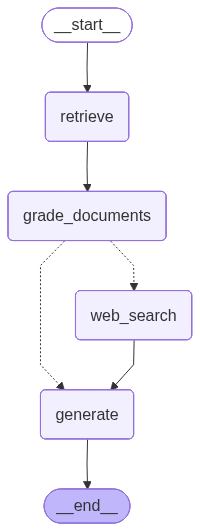

In [8]:
from IPython.display import Image, display

# Display graph
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization requires graphviz.")
    print("\nWorkflow structure:")
    print("START → retrieve → grade_documents → [decision]")
    print("                                        ├→ generate (if docs relevant)")
    print("                                        └→ web_search → generate (if not)")

## Example usage: 1. High Confidence Path

When the query matches our internal knowledge base (API docs, deployment procedures), documents score as relevant and confidence is high. The agent generates answers directly from company documentation.

In [9]:
# Query that matches company knowledge base
question1 = "What are our API rate limits for different tiers?"

print(f"Query: {question1}")
print("="*70)

result = app.invoke({"question": question1})

print("\n" + "="*70)
print("FINAL ANSWER:")
print(result["generation"])

Query: What are our API rate limits for different tiers?

🔍 RETRIEVE: Found 3 documents from knowledge base
  Doc 1 [api/platform]: API rate limits: Free tier allows 100 requests per day with 1 req/second limit. ...
  Doc 2 [operations/sre]: Performance monitoring: API latency p95 should be under 200ms. Database query ti...
  Doc 3 [support/customer-success]: Support SLA: Premium customers get 1-hour response time for critical issues. Sta...

⚖️  GRADE DOCUMENTS: Evaluating 3 documents
  Document 1: ✅ Relevant
  Document 2: ❌ Not relevant
  Document 3: ❌ Not relevant

🟡 MODERATE CONFIDENCE: Partial document relevance
   → 1/3 documents are relevant
  → Decision: Sufficient relevant documents found
  → Proceeding to GENERATE from documents

📝 GENERATE: Using internal knowledge base

FINAL ANSWER:
**API Rate Limits by Tier**

| Tier | Daily Request Limit | Per‑Second Request Limit |
|------|---------------------|--------------------------|
| **Free** | 100 requests per day | 1 request pe

## Example usage: 2. Low Confidence Path

When queries ask about external topics (market trends, competitor analysis, latest tech developments), internal documents don't match. The agent transparently switches to web search for current external information.

In [12]:
# Query outside company knowledge base
question2 = "Who is Abhijit Mandal from Qubrid AI?"

print(f"Query: {question2}")
print("="*70)

result = app.invoke({"question": question2})

print("\n" + "="*70)
print("FINAL ANSWER:")
print(result["generation"])

Query: Who is Abhijit Mandal from Qubrid AI?

🔍 RETRIEVE: Found 3 documents from knowledge base
  Doc 1 [security/security]: Security best practices: All passwords must be hashed with bcrypt. Enable 2FA fo...
  Doc 2 [operations/engineering]: On-call rotation: Engineering team rotates weekly. Primary on-call must respond ...
  Doc 3 [engineering/platform]: Code review policy: All PRs require 2 approvals before merge. Security-critical ...

⚖️  GRADE DOCUMENTS: Evaluating 3 documents
  Document 1: ❌ Not relevant
  Document 2: ❌ Not relevant
  Document 3: ❌ Not relevant

🔴 LOW CONFIDENCE: Poor document relevance
   → Only 0/3 documents are relevant
  → Decision: No relevant documents found
  → Switching to WEB SEARCH for better results

🌐 WEB SEARCH: Searching the web via Tavily
  Query: Who is Abhijit Mandal from Qubrid AI?
  ✓ Found 3 relevant results

📝 GENERATE: Using web search

FINAL ANSWER:
Abhijit Mandal is an **Artificial Intelligence Engineer** (AI Engineer) at **Qubrid AI**, b

## Summary

We've built a confidence-aware RAG agent for SaaS company knowledge management that goes beyond simple retrieval by:

- **Transparent Grading**: Shows relevance score for each retrieved document with metadata (category, team)
- **Confidence Display**: Expresses confidence levels (high/moderate/low) with visual indicators
- **Adaptive Strategy**: Switches to web search when internal documentation is insufficient
- **Clear Decision-Making**: Users see exactly why the agent chose internal docs vs external search

This approach enables trust and transparency in enterprise knowledge systems, especially for companies with rich internal documentation that need to supplement with external information when necessary.

---

###  Start Building Your Agents Now


**[🔑 Get API Key](https://platform.qubrid.com/signup)** | **[🤖 Explore Models](https://docs.platform.qubrid.com/inferencing/Serverless%20Models)** | **[🎮 Try Playground](https://platform.qubrid.com/playground)**


Transform your ideas into agentic workflows with Qubrid AI.